# Кластеризация в PySpark

## Цели
* Скачать washing.parquet
* Применить метод главных компонент.
* Выполнить кластеризацию.

# Импорт библиотек и загрузка данных

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Определим SparkContext и SparkSession.

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

22/04/06 19:32:02 WARN Utils: Your hostname, D9NA5NC resolves to a loopback address: 127.0.1.1; using 172.22.118.148 instead (on interface eth0)
22/04/06 19:32:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/06 19:32:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Отключаем предупреждения PySpark
sc.setLogLevel("ERROR")

In [4]:
spark

# Кластеризация

Создадим датафрейм из PARQUET файла.

In [5]:
df = spark.read.parquet('./washing.parquet')
df.createOrReplaceTempView('washing')
df.show(10)

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

При помощи spark.sql и оконных функций (sliding window, нарастание идет по timestamp) получим новые признаки из существующих.

In [6]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temp,
    max(temperature) over w as max_temp,
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    avg(flowrate) over w as avg_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    avg(hardness) over w as avg_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temp is not null 
AND min_voltage is not null
AND avg_flowrate is not null
AND min_frequency is not null
AND avg_hardness is not null
AND min_speed is not null
""")

In [7]:
result.createOrReplaceTempView('result')
# Выведем результат в красивом табличном виде.
result.toPandas().head(10)

,min_temp,max_temp,min_voltage,max_voltage,avg_flowrate,min_frequency,max_frequency,avg_hardness,min_speed,max_speed
0,81,100,221,223,11.0,68,76,74.000000,1033,1033
1,81,100,221,223,11.0,68,76,74.428571,1033,1033
2,81,100,221,223,11.0,68,76,75.571429,1033,1033
3,81,100,222,223,11.0,68,74,75.571429,1033,1046
4,81,100,222,223,11.0,68,74,76.285714,1033,1046
5,80,94,222,223,11.0,68,74,76.714286,1033,1046
6,80,94,222,236,11.0,68,74,76.714286,1046,1046
7,80,94,222,236,11.0,68,74,77.000000,1046,1046
8,80,94,222,236,11.0,71,74,76.750000,1046,1046
9,80,94,222,236,11.0,71,74,77.250000,1046,1046


Фцнкция для вывода среднего и стандартоного отклонения через SQL запрос.

In [8]:
def custom_func(param):
    return spark.sql(f"""SELECT avg({param}) as mean,
    STD({param}) as sdt
    from result
""").show()

In [9]:
custom_func("max_temp")

+-----------------+------------------+
|             mean|               sdt|
+-----------------+------------------+
|97.99317406143345|2.2603587495167865|
+-----------------+------------------+



In [10]:
custom_func("max_voltage")

+------------------+-----------------+
|              mean|              sdt|
+------------------+-----------------+
|234.96099463676256|7.372092384945179|
+------------------+-----------------+



Создадим features с помощью векторного преобразования, а затем уменьшим число измерений через PCA (метод главных компонент). VectorAssembler нужен чтобы импортировать данные в PCA.

In [11]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")
features = assembler.transform(result)
features.rdd.map(lambda r: r.features).take(5)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 68.0, 76.0, 74.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 68.0, 76.0, 74.4286, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 68.0, 76.0, 75.5714, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 68.0, 74.0, 75.5714, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 68.0, 74.0, 76.2857, 1033.0, 1046.0])]

Уменьшим число измерений до 4 чтобы можно было графически представить результат.

In [12]:
pca = PCA(k=4, inputCol="features", outputCol="pca_features")

In [13]:
model = pca.fit(features).transform(features)
result_pca = model.select("pca_features")
result_pca.show(5, truncate=False)

+----------------------------------------------------------------------------+
|pca_features                                                                |
+----------------------------------------------------------------------------+
|[1458.4274218210676,74.16372311552368,-17.158299129354386,332.3685442718059]|
|[1458.4387084161517,74.18595404767007,-17.585680835235802,332.3857375659293]|
|[1458.4688060030426,74.24523653339372,-18.725365384252893,332.4315863502583]|
|[1468.087701349808,65.4808960182628,-18.892397134675523,333.1333437918539]  |
|[1468.1065123416151,65.51794757184007,-19.604699977811197,333.1619992820595]|
+----------------------------------------------------------------------------+
only showing top 5 rows



Визуализируем данные. Теперь можно даже графически отметить наличие 2 кластеров.

In [14]:
# Инициализируем пустой массив
draw = np.empty([4, result_pca.count()])

# Заполним массив значениями для построения трехмерного скаттерплота.
for i in range(4):
    draw[i] = result_pca.rdd.map(lambda x: x.pca_features[i]).collect()

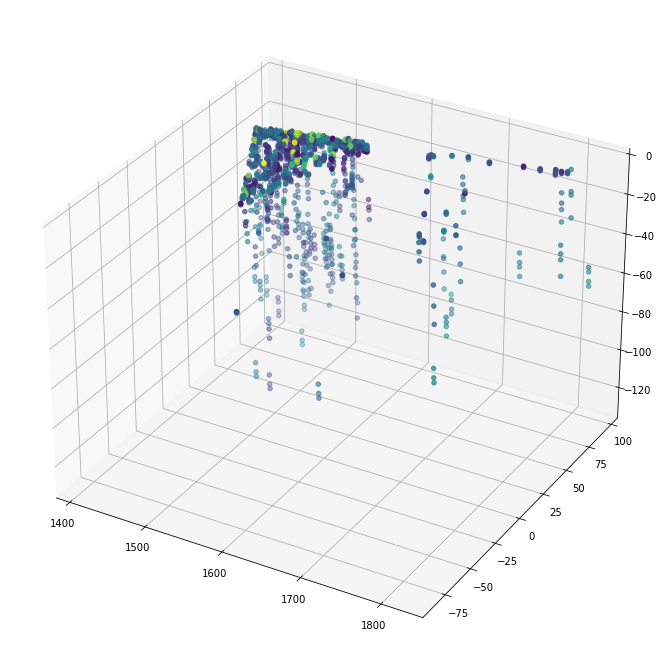

In [15]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
# sns.set_theme(style="darkgrid")

ax.scatter(xs=draw[0],
           ys=draw[1],
           zs=draw[2],
           c=draw[3])

plt.show()

Проверим предположения воспользовавшись KMeans.

In [16]:
# Создадим модель с K=2.
kmeans = KMeans().setK(2).setSeed(38)
model = kmeans.fit(features)

# Получим predictions и оценим насколько хорошо отработала кластеризация.
predictions = model.transform(features)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)

print(f"Silhouette с квадратом евклидова расстояния: {str(silhouette)[:5]}")

Silhouette с квадратом евклидова расстояния: 0.912


# Выводы

* Получены необходимые признаки с применением оконных функций.
* Выполнено PCA преобразование.
* Построен трехмерный скаттерплот.
* Определено число кластеров. Silhouette почти равен 1, а значит кластеры расположены достаточно далеко друг от друга и определены корректно.